# Constitutive regions analysis

In [4]:
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import pickle
import sys
import tensorflow as tf
import importlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random

2022-02-24 13:07:41.264121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-24 13:07:41.264139: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
filepath =  "/home/luisasantus/Desktop/crg_cluster/data/FED/suppl_df.pkl"
with open(filepath, 'rb') as file:
    suppl_df = pickle.load(file) 

def sub_labels(item):
    if(item == "DNase"):
        item = item.replace("DNase","DNase/ATAC")
    elif(item == "ATAC"):
        item = item.replace("ATAC","DNase/ATAC")
    return(item)         
    
suppl_df["short_assay"] = list(map(sub_labels,suppl_df.assay_subtype ))

In [3]:
# Save human and mouse 
# ----------- Human
suppl_df_human = suppl_df[suppl_df.organism == "human"]
filepath =  "/home/luisasantus/Desktop/crg_cluster/data/FED/suppl_human.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(suppl_df_human, file) 
    
# ------------ Mouse    
suppl_df_mouse = suppl_df[suppl_df.organism == "mouse"]
filepath =  "/home/luisasantus/Desktop/crg_cluster/data/FED/suppl_mouse.pkl"
with open(filepath, 'wb') as file:
    pickle.dump(suppl_df_mouse, file) 

## 1 Call peaks

In [4]:
test =  "/home/luisasantus/Desktop/crg_cluster/data/FED/basenji/human/test_197.pkl"
with open(test, 'rb') as file:
    dataset = pickle.load(file) 

2022-02-22 17:06:41.182071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-22 17:06:41.182114: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-22 17:06:41.182148: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luisasantus-HP-EliteDesk-800-G5-TWR): /proc/driver/nvidia/version does not exist
2022-02-22 17:06:41.182689: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    print(zip(axes, tracks.items()))
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()
     
def get_tracks(dataset, indeces):
    tracks ={}
    for i in range(len(indeces)):
        tracks[indeces.loc[i, "description"]] = dataset[:,int(indeces.loc[i, "index"])]
    return(tracks)

In [6]:
batch = test_file[0]
CAGE_index_description = suppl_df[suppl_df.assay_type == "CAGE"][list(["index", "description"])].reset_index()

NameError: name 'test_file' is not defined

In [7]:
# Select 5 random tracks per assay to visualize 
# Also visualize the "called" intersection 
CAGE_tracks = get_tracks(batch["target"], CAGE_index_description)

# Subsample tracks to plot
n = 5
keys = random.sample(CAGE_tracks.keys(), n)
CAGE_tracks_n = {k: CAGE_tracks[k] for k in keys}

plot_tracks(CAGE_tracks_n, batch["interval"])

NameError: name 'batch' is not defined

In [333]:
track_id = list(CAGE_tracks_n.keys())[0]
df = CAGE_tracks_n[track_id]
print(track_id)

c = 1
height=0.1
fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
for ax, (title, y) in zip(axes, tracks.items()):
    ax.tick_params(left=False, bottom=False)
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    plt.plot(np.where(df.numpy() > c,0, None), color="red",  linewidth=5)
    sns.despine(top=True, right=True, left = True, bottom=True)
    
p = plt.plot(np.where(df.numpy() > c,0, None), color="red",  linewidth=5)

CAGE:Smooth Muscle Cells - Umbilical Artery,


## 2 Find intersection tracks 
### Per sequence, per assay 

In [8]:
# Convert tracks to binary track (yes or no)
def to_binary_track(track_values, c):
    return(np.where(track_values > c,0, None))

def get_assay_only(values, assay, suppl_df):
    indeces = suppl_df[suppl_df.short_assay == assay].index
    return(values[:,list(indeces)])  

def keep_position(row, threshold_intersection):
    prop_not_null = (row.tolist().count(0)/row.shape[0])*100
    if prop_not_null >= threshold_intersection: 
        return True
    else: 
        return False
    
# For one sequence 
def get_intersection(batch, sequence, assays, threshold_peak, threshold_intersection, subset = "target"):
    columns = list(["sequence", "assay", "threshold_peak", "threshold_int", "value", "chr", "start", "end"])
    assays_intersections = pd.DataFrame(columns=columns)
    for assay in assays: 
        targets = get_assay_only(batch[subset].numpy(), assay, suppl_df)
        targets_binary = to_binary_track(targets, threshold_peak)
        intersection_position = np.apply_along_axis(keep_position, 1, targets_binary, threshold_intersection)
        intersection_perc = (list(intersection_position).count(True)/len(intersection_position))*100
        # Extract interval info 
        interval = batch["interval"]
        # Create dataset entry 
        entry = pd.DataFrame(list([sequence, assay, threshold_peak, threshold_intersection, intersection_perc, interval.chrom, interval.start, interval.end])).T
        entry.columns = columns
        assays_intersections = assays_intersections.append(entry)
    return(assays_intersections)

In [334]:
#dataset_197k_file = "/home/luisasantus/Desktop/crg_cluster/data/FED/basenji/human/tfrecords_197k/valid-0-0_197k.pkl"
#with open(dataset_197k_file, 'rb') as file:
#    dataset = pickle.load(file) 

In [463]:
assay_intersection_summary = []
threshold_peak = 0
threshold_intersection = 50
assays = list(set(suppl_df.short_assay))

intersection_thresholds = range(0,101,20)

# For each sequence in the dataset
max_steps = 1
df_thresholds_benchmark = pd.DataFrame()
for i, batch in enumerate(dataset):
    for threshold_intersection in intersection_thresholds: 
        inte = get_intersection(batch, i, assays, threshold_peak, threshold_intersection)
        df_thresholds_benchmark  = df_thresholds_benchmark.append(inte)
    if i > max_steps: 
        break

In [464]:
df_summarized = df_thresholds_benchmark.groupby(list(["assay", "threshold_peak", "threshold_int"])).mean().reset_index()
df_summarized

,assay,threshold_peak,threshold_int,sequence,value
0,CAGE,0,0,1.0,100.000000
1,CAGE,0,20,1.0,17.038690
2,CAGE,0,40,1.0,3.534226
3,CAGE,0,60,1.0,1.078869
4,CAGE,0,80,1.0,0.446429
5,CAGE,0,100,1.0,0.000000
6,ChIP-Histone,0,0,1.0,100.000000
7,ChIP-Histone,0,20,1.0,96.316964
8,ChIP-Histone,0,40,1.0,92.038690
9,ChIP-Histone,0,60,1.0,76.041667


### Plot

In [41]:
df_summarized

0              ChIP-TF
1         ChIP-Histone
2                 CAGE
3           DNase/ATAC
4              ChIP-TF
              ...     
314407      DNase/ATAC
314408         ChIP-TF
314409    ChIP-Histone
314410            CAGE
314411      DNase/ATAC
Name: assay, Length: 314412, dtype: category
Categories (4, object): ['DNase/ATAC', 'ChIP-TF', 'ChIP-Histone', 'CAGE']

In [76]:
def get_df_summarized(head):
    datadir = "../../../../../data/FED/basenji/"+head+"/stats/"
    file = os.path.join(datadir,'thresholds_intersection.csv')
    df_summarized= pd.read_csv(file, sep = "\t")
    df_summarized = df_summarized[df_summarized.assay != "assay"]
    df_summarized.value = list(map(float, df_summarized.value))
    df_summarized["organism"] = head
    return(df_summarized)

In [86]:
df_summarized_human = get_df_summarized("human")
df_summarized_mouse = get_df_summarized("mouse")
df_summarized = df_summarized_human.append(df_summarized_mouse)
df_summarized = df_summarized.reset_index()

In [87]:
df_summarized.head()

,index,sequence,assay,threshold_peak,threshold_int,value,chr,start,end,organism
0,0,valid-0-0_197k.pkl_0,ChIP-TF,0,0,100.0,chr6,165740202,165871274,human
1,1,valid-0-0_197k.pkl_0,ChIP-Histone,0,0,100.0,chr6,165740202,165871274,human
2,2,valid-0-0_197k.pkl_0,CAGE,0,0,100.0,chr6,165740202,165871274,human
3,3,valid-0-0_197k.pkl_0,DNase/ATAC,0,0,100.0,chr6,165740202,165871274,human
4,4,valid-0-0_197k.pkl_0,ChIP-TF,0,5,100.0,chr6,165740202,165871274,human


In [88]:
df_summarized['assay'] = df_summarized['assay'].astype('category')
df_summarized.head()

,index,sequence,assay,threshold_peak,threshold_int,value,chr,start,end,organism
0,0,valid-0-0_197k.pkl_0,ChIP-TF,0,0,100.0,chr6,165740202,165871274,human
1,1,valid-0-0_197k.pkl_0,ChIP-Histone,0,0,100.0,chr6,165740202,165871274,human
2,2,valid-0-0_197k.pkl_0,CAGE,0,0,100.0,chr6,165740202,165871274,human
3,3,valid-0-0_197k.pkl_0,DNase/ATAC,0,0,100.0,chr6,165740202,165871274,human
4,4,valid-0-0_197k.pkl_0,ChIP-TF,0,5,100.0,chr6,165740202,165871274,human


In [93]:
df_summarized['assay'] = df_summarized['assay'].cat.reorder_categories(['DNase/ATAC', 'ChIP-TF', "ChIP-Histone", "CAGE"])
df_summarized.head()

,index,sequence,assay,threshold_peak,threshold_int,value,chr,start,end,organism
0,0,valid-0-0_197k.pkl_0,ChIP-TF,0,0,100.0,chr6,165740202,165871274,human
1,1,valid-0-0_197k.pkl_0,ChIP-Histone,0,0,100.0,chr6,165740202,165871274,human
2,2,valid-0-0_197k.pkl_0,CAGE,0,0,100.0,chr6,165740202,165871274,human
3,3,valid-0-0_197k.pkl_0,DNase/ATAC,0,0,100.0,chr6,165740202,165871274,human
4,4,valid-0-0_197k.pkl_0,ChIP-TF,0,5,100.0,chr6,165740202,165871274,human


In [98]:
df_summarized["value"] = list(map(float, df_summarized.value))

([<matplotlib.axis.YTick at 0x7fa772cab760>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

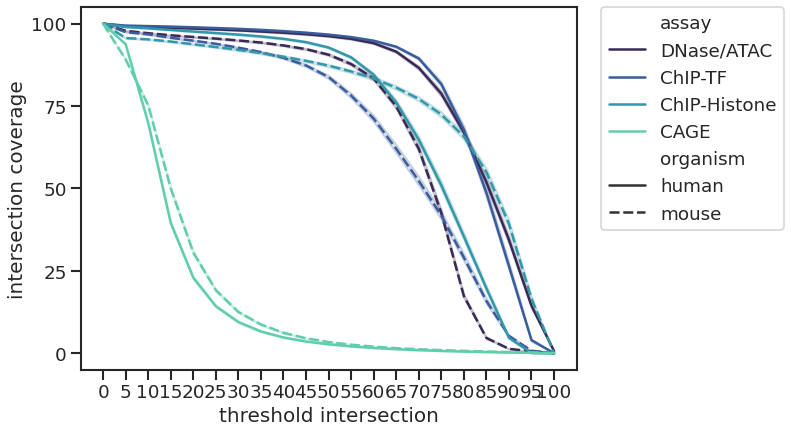

In [103]:
sns.set_context("talk")
sns.set_style("ticks")
plt.figure(figsize=(8, 6), dpi=80)

sns.lineplot(data=df_summarized, x="threshold_int", y="value", hue = "assay", palette = "mako", style="organism")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("threshold intersection")
plt.ylabel("intersection coverage")
plt.yticks(range(0, 101, 25))

In [105]:
df_summarized_human = df_summarized[df_summarized.organism == "human"]
df_summarized_mouse = df_summarized[df_summarized.organism == "mouse"]

([<matplotlib.axis.YTick at 0x7fa772a93640>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

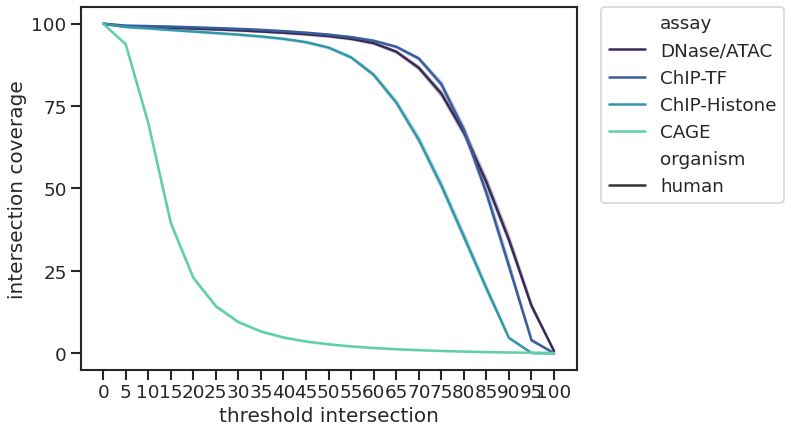

In [106]:
sns.set_context("talk")
sns.set_style("ticks")
plt.figure(figsize=(8, 6), dpi=80)

sns.lineplot(data=df_summarized_human, x="threshold_int", y="value", hue = "assay", palette = "mako", style="organism")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("threshold intersection")
plt.ylabel("intersection coverage")
plt.yticks(range(0, 101, 25))

([<matplotlib.axis.YTick at 0x7fa772a91f40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

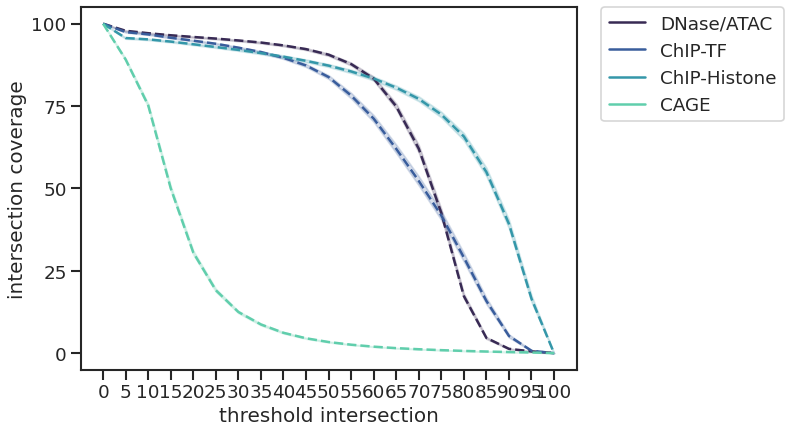

In [109]:
sns.set_context("talk")
sns.set_style("ticks")
plt.figure(figsize=(8, 6), dpi=80)

sns.lineplot(data=df_summarized_mouse, x="threshold_int", y="value", hue = "assay", palette = "mako", linestyle='--')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("threshold intersection")
plt.ylabel("intersection coverage")
plt.yticks(range(0, 101, 25))